<a href="https://colab.research.google.com/github/samirapakravan/ML_Challenge/blob/main/postera_lstm_problem_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 19.0 MB/s eta 0:00:00


In [2]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole 

import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import trange

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True


#**Medium Problem**

Reading file contents and filtering the SMILES to those with at most 50 characters:

In [3]:
zinc_df = pd.read_csv('SMILES_Keyboard.csv')
zinc_df = zinc_df.loc[zinc_df['SMILES'].str.len()<50][['SMILES', 'NAME']].reset_index(drop=True)

In [4]:
zinc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  11808 non-null  object
 1   NAME    11808 non-null  object
dtypes: object(2)
memory usage: 184.6+ KB


##**Method 1:** Natural Language Processing technique; i.e., neighborhood in latent space.



###**Tokenization and Encoding** 

Tokenizer function to separate SMILES strings into separate tokens:

In [5]:
def smi_tokenizer(smi):
    """
    Tokenize a SMILES molecule or reaction
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return ' '.join(tokens)

In [6]:
smi_tokenizer(zinc_df['SMILES'][1])

'C c 1 c c ( - n 2 n c c ( = O ) [nH] c 2 = O ) c c c 1 C ( = O ) c 1 c c c ( C # N ) c c 1'

Finding all the unique tokens and encoding the entire dataset using 2 dictionaries that convert token to integer and integer to token

In [7]:
# Method 1 token based

tokenized_data = ""
for i, row in zinc_df.iterrows():
  t = smi_tokenizer(row['SMILES'])
  tokenized_data += t

tokenSet = set()
txt = []
for token in tokenized_data.split(" "):
  txt.append(token)
  tokenSet.add(token)

int2token = dict(enumerate(tokenSet))
token2int = {t: id for id, t in int2token.items()}
encoded = np.array([token2int[t] for t in txt])

In [8]:
# Method 2 char based

#tokenSet = set("".join(list(zinc_df.SMILES))+"!E")
#txt = "".join(list(zinc_df.SMILES))+"!E"

tokenSet = set("".join(list(zinc_df.SMILES)))
txt = "".join(list(zinc_df.SMILES))

int2token = dict(enumerate(tokenSet))
token2int = {t: id for id, t in int2token.items()}
encoded = np.array([token2int[t] for t in txt])

Creating one hot encoding: creating column vector based on the integer values of tokens

In [9]:
def one_hot_encode(encoded, n_uni_tokens):
    one_hot = np.zeros((encoded.size, n_uni_tokens), dtype=np.float32)  # starting with zeros
    one_hot[np.arange(one_hot.shape[0]), encoded.flatten()] = 1.0       # wherever index position meets set it 1
    one_hot = one_hot.reshape((*encoded.shape, n_uni_tokens))           # reshape to get the original batch shape   
    return one_hot

###**Generating Training Batches** 

Each training sample is a sequence of tokens along with a label which is the same sequence shifted by 1 time step

In [10]:
def generate_batches(encoded, batch_size, seq_len):
    token_per_batch = batch_size * seq_len            # total number of tokens per batch
    n_batches = len(encoded)//token_per_batch         # total number of batches we can make out of all data
    
    encoded = encoded[:n_batches * token_per_batch]   # cut of the end of encoded
    encoded = encoded.reshape((batch_size, -1))       # reshape encoded data into rows of size batch
    
    for n in range(0, encoded.shape[1], seq_len):     # encoded is reshaped now so we go along dimension 1
        x = encoded[:, n:n+seq_len]
        y = np.zeros_like(x)                          # creating array of zeros with same shape as x
        
        try:
            y[:,:-1] = x[:,1:]
            y[:,-1] = encoded[:,n+seq_len]       
        except:                             # at the end there is a possibility to go out of range
            y[:,:-1] = x[:,1:]
            y[:,-1] = encoded[:,0]
        yield x, y

###**Creating NN Model** 

In [11]:
class Model(nn.Module):
    
    def __init__(self, tokens, n_hidden=10, n_layers=2):
        super().__init__()

        self.n_layers = n_layers
        self.n_hidden = n_hidden

        # our built-in dictionaries
        self.tokens = tokens
        self.int2token = dict(enumerate(self.tokens))
        self.token2int = {t: id for id, t in int2token.items()}
        
        self.lstm = nn.LSTM(len(self.tokens), n_hidden, n_layers, dropout=0.2, batch_first=True)   # batch_first=True --> (batch, seq, feature)
        self.dropout = nn.Dropout(0.2)                                                             # Dropout layer to avoid overfitting
        self.fc = nn.Linear(n_hidden, len(self.tokens)) 

    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)      
        out = self.dropout(lstm_out)  
        out = out.contiguous().view(-1, self.n_hidden)       # Correct the view so we can pass it to the fc layer    
        out = self.fc(out)   
        return out, hidden   

    def hidden_state(self, batch_size):
        hidden = (torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device), torch.zeros(self.n_layers, batch_size, self.n_hidden).to(device))        
        return hidden

In [12]:
n_hidden=50
n_layers=5
model = Model(tokenSet, n_hidden, n_layers).to(device)
print(model)

Model(
  (lstm): LSTM(37, 50, num_layers=5, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=37, bias=True)
)


In [13]:
indx = int(len(encoded)*(1-0.1))
train, test = encoded[:indx], encoded[indx:]

In [14]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [15]:
epochs = 50
b = 0
batch_size = 32
seq_length = 40
n_uni_tokens = len(model.tokens)

In [16]:
model.train()

for i in range(epochs):
    h = model.hidden_state(batch_size)
    
    for x, y in generate_batches(train, batch_size, seq_length):    # Creating input and target batches
        b += 1

        x = one_hot_encode(x, n_uni_tokens)                         # Creating one_hot_encoding of input
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)  # Creating a Tensor from a numpy.ndarray
        inputs, targets = inputs.to(device), targets.to(device)     # Using available device

        h = tuple([each.data for each in h]) # Resetting the hidden state, if we don't reset it, it will backprop into all training

        optimizer.zero_grad()
        
        output, h = model(inputs, h)     
        loss = loss_fn(output, targets.view(batch_size*seq_length).long())  # Calculating the loss with correct shape of target
        loss.backward()                                                     # Performs backpropagation
        optimizer.step()     # Updates the value of parameters according to the optimization strategy
        
        if b % 100 == 0:
            val_h = model.hidden_state(batch_size)
            val_losses = []
            model.eval()      # Changing to evaluation mode and doing the same process on test data

            for x, y in generate_batches(test, batch_size, seq_length):
                x = one_hot_encode(x, n_uni_tokens)
                x, y = torch.from_numpy(x), torch.from_numpy(y)

                val_h = tuple([each.data for each in val_h])
                
                inputs, targets = x, y
                inputs, targets = inputs.to(device), targets.to(device)

                output, val_h = model(inputs, val_h)
                val_loss = loss_fn(output, targets.view(batch_size*seq_length).long())
            
                val_losses.append(val_loss.item())
            
            model.train()      # Changing back to evaluation mode
            print(f"Epoch:{i}   Loss:{loss.item()}    Val_Loss: {np.mean(val_losses)}")

Epoch:0   Loss:2.4478812217712402    Val_Loss: 2.4367823528520987
Epoch:0   Loss:2.397529125213623    Val_Loss: 2.4335754423430473
Epoch:1   Loss:2.4727389812469482    Val_Loss: 2.433168823068792
Epoch:1   Loss:2.3781213760375977    Val_Loss: 2.433563644235784
Epoch:1   Loss:2.3731837272644043    Val_Loss: 2.432621796925863
Epoch:2   Loss:2.419724941253662    Val_Loss: 2.4332144260406494
Epoch:2   Loss:2.38234281539917    Val_Loss: 2.4320300058885054
Epoch:2   Loss:2.3845646381378174    Val_Loss: 2.432343345699888
Epoch:3   Loss:2.413770914077759    Val_Loss: 2.432167371114095
Epoch:3   Loss:2.3881001472473145    Val_Loss: 2.4314578663219106
Epoch:3   Loss:2.395935297012329    Val_Loss: 2.431012168075099
Epoch:4   Loss:2.066490650177002    Val_Loss: 2.122770916331898
Epoch:4   Loss:1.9927459955215454    Val_Loss: 2.0292302695187656
Epoch:4   Loss:1.909767746925354    Val_Loss: 1.9095187295566907
Epoch:5   Loss:1.8683990240097046    Val_Loss: 1.8307336099220044
Epoch:5   Loss:1.82532465

In [17]:
def predict(model, token, hidden=None, top_k=1):

  encoded_text = model.token2int[token]                           # Encode the token                  
  encoded_text = np.array([[encoded_text]])
  encoded_text = one_hot_encode(encoded_text, len(model.tokens))  # one-hot-encode the token
  encoded_text = torch.from_numpy(encoded_text)
  encoded_text = encoded_text.to(device)

  hidden = tuple([state.data for state in hidden])
  out, hidden = model(encoded_text, hidden)                       # Run the model

  probs = F.softmax(out, dim=1).data                              # Convert out to probabilities
  probs = probs.cpu()

  probs, index = probs.topk(top_k)                            # Returns the top ks
  
  index = index.numpy().squeeze()
  probs = probs.numpy().squeeze()

  token = np.random.choice(index, p=probs/probs.sum())   # Convert probabilities per index and chose token based on that
  
  return model.int2token[token], hidden

In [18]:

  def sample(model, size, prime='The', top_k=None):

    
    model.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = model.hidden_state(1)
    for ch in prime:
        char, h = predict(model, ch, h, top_k=top_k)
    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(model, chars[-1], h, top_k=top_k)
        chars.append(char)
    return ''.join(chars)

In [19]:
def result(prefix):
 
  while len(s)<6:
    result = sample(model, 2, prime=prefix, top_k=5)
    mol = Chem.MolFromSmiles(result)
    if result not in s and mol:
      print(f'SMI:  {result}')
      s.add(str(result))

In [20]:
prefix = input('Please enter your prefix: ')
s = set()
result(prefix)

Please enter your prefix: CCc1ccc
SMI:  CCc1cccnc1
SMI:  CCc1ccccc1
SMI:  CCc1ccccn1
SMI:  CCc1cccnn1
SMI:  CCc1cccn1C
SMI:  CCc1cccn1O


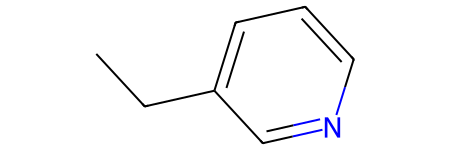

In [21]:
Chem.MolFromSmiles('CCc1cccnc1')

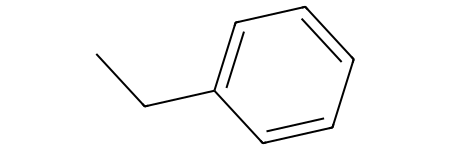

In [22]:
Chem.MolFromSmiles('CCc1ccccc1')

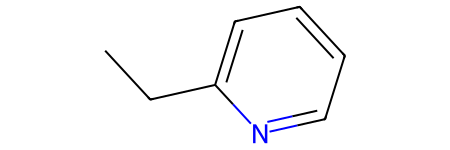

In [23]:
Chem.MolFromSmiles('CCc1ccccn1')

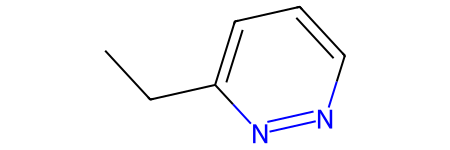

In [24]:
Chem.MolFromSmiles('CCc1cccnn1')

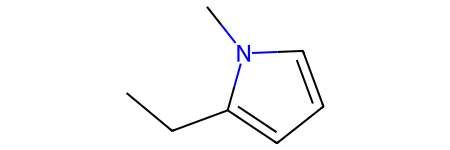

In [25]:
Chem.MolFromSmiles('CCc1cccn1C')

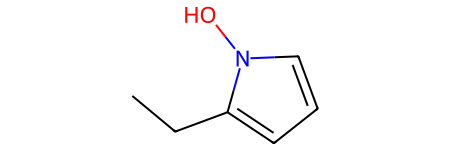

In [26]:
Chem.MolFromSmiles('CCc1cccn1O')